# IA API Workshop Notebook

This notebook contains a tutorial for using the various APIs at the Internet Archive via Python.

Rather than using command line tools such as `curl` and `jq` to parse information, we will use Python to process each file. This will make it easy to visualize the data and do advanced transformations on the results.

## Libraries


Python's standard library includes [`http`](https://docs.python.org/3/library/http.html) and [`urllib.request`](https://docs.python.org/3/library/urllib.request.html) modules for retrieving data from API endpoints. However, the documentation itself recommends using [`requests`](http://docs.python-requests.org/en/master/), a third-party library for interacting with APIs.

One very useful part of requests is built in `json` and HTTP authentication support.

We also use [`matplotlib`](https://matplotlib.org/) for visualization, especially the [`pyplot`](https://matplotlib.org/api/pyplot_summary.html) module

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import requests

# APIs

## Wayback Availability API

We start with the Wayback Availability API. First, we use `requests.get()` to complete a request cycle. Then, we show how to genericize the request into a function that handles cases when Wayback is not available.

In [2]:
# Demonstrate a successful Wayback Availability query
URL = 'example.com'
r = requests.get('http://archive.org/wayback/available?url={}'.format(URL))
r.json()

{'archived_snapshots': {'closest': {'available': True,
   'status': '200',
   'timestamp': '20170925160637',
   'url': 'http://web.archive.org/web/20170925160637/http://example.com'}},
 'url': 'example.com'}

In [3]:
# Demonstrate an unsuccessful Wayback Availability query
URL = 'foo.example.com'
r = requests.get('http://archive.org/wayback/available?url={}'.format(URL))
r.json()

{'archived_snapshots': {}, 'url': 'foo.example.com'}

In [4]:
# convert to a boolean function
def available(URL):
    r = requests.get('http://archive.org/wayback/available?url={}'.format(URL))
    data = r.json()
    return bool(data['archived_snapshots'])

print("example.com", available('example.com'))
print("foo.example.com", available('foo.example.com'))

example.com True
foo.example.com False


## Wayback CDX API

The Wayback CDX (Capture InDeX) contains records in an 11-column table that uses URL and timestamp as keys. This is an API that truly benefits from Python usage, as we can build a custom parsing function to extract the values from the CDX records.

In [5]:
r = requests.get('http://web.archive.org/cdx/search?url=example.com')

In [10]:
import csv
from io import StringIO
from datetime import datetime

def parse_cdx(URL):
    """
    Parses the data from a Wayback CDX API request and returns a generator of CDX data.
    It converts the timestamp, statuscode, and length into native datatypes.
    """
    FIELDS = ['urlkey', 'timestamp', 'original', 'mimetype', 'statuscode', 'digest', 'length']
    r = requests.get('http://web.archive.org/cdx/search?url={}'.format(URL))
    text = StringIO(r.text)
    reader = csv.DictReader(text, fieldnames=FIELDS, delimiter=' ')
    for row in reader:
        try:
            row['timestamp'] = datetime.strptime(row['timestamp'], '%Y%m%d%H%M%S')
            row['length'] = 0 if row['statuscode'] == '-' else int(row['length'])
            yield row
        except ValueError:
            pass

# Note, this only returns the generator! Not a list!
parse_cdx('example.com')

<generator object parse_cdx at 0x7f57e10f7150>

### CDX API Example: counting response codes

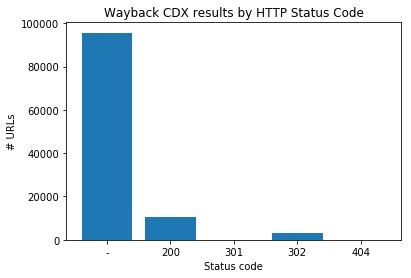

In [11]:
from collections import defaultdict

counts = defaultdict(int)
for row in parse_cdx('example.com'):
    counts[row['statuscode']] += 1

# get the values and sort them
codes = sorted(counts.keys())
data = [counts[code] for code in codes]

# plot the data
plt.title("Wayback CDX results by HTTP Status Code")
plt.bar(np.arange(len(data)), data)
plt.xlabel("Status code")
plt.ylabel("# URLs")
plt.xticks(np.arange(len(data)), codes)
plt.show()

You'll notice that most of the requests have a status code of `-`. These entries also have a mime-type of `warc/revisit`. 

```
com,example)/ 20090925093245 http://www.example.com/ warc/revisit - EF7YLJGKQUMLJFP3F7A7LBALC65T5W2O 498
```

`warc/revisit` refers to an entry that was crawled, but revealed to have no change in content from the last crawl. Rather than store the same data twice, we simply mark that it was unchanged and continue with the crawl. This drastically reduces the size of the WARC files, but creates some usability issues when it comes to issues like this.

We handle revisits by setting their `length` to zero, so it does not increase the crawl size statistics.
When calculating response code stats, we skip the `-` status code CDX entries.
When calculating crawl visit statistics, we include the `-` status code CDX entries.



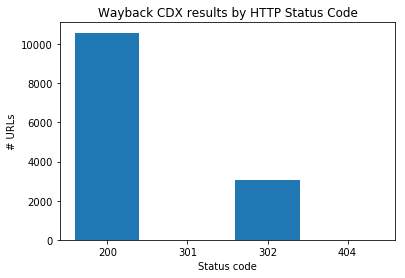

In [12]:
from collections import defaultdict

counts = defaultdict(int)
for row in parse_cdx('example.com'):
    if row['statuscode'] is not '-':
        counts[row['statuscode']] += 1

# get the values and sort them
codes = sorted(counts.keys())
data = [counts[code] for code in codes]

# plot the data
plt.title("Wayback CDX results by HTTP Status Code")
plt.bar(np.arange(len(data)), data)
plt.xlabel("Status code")
plt.ylabel("# URLs")
plt.xticks(np.arange(len(data)), codes)
plt.show()

**Much better!**

### CDX API Example: Cumulative Capture Size

In this example, we will use the time stamps to plot how much data was collected over time per URL. 

It uses the [`matplotlib.dates`](https://matplotlib.org/api/dates_api.html) library to improve the chart legibility.

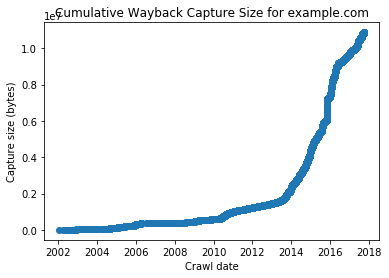

In [13]:
import matplotlib.dates as mdates

URL = 'example.com'

# aggregate the data
dates = []; lengths = []
for row in parse_cdx(URL):
    dates.append(mdates.date2num(row['timestamp']))
    lengths.append(row['length'])

# sort the data
dates, lengths = zip(*sorted(zip(dates, lengths)))

# plot the data
plt.title("Cumulative Wayback Capture Size for {}".format(URL))
plt.plot_date(dates, np.cumsum(lengths))
plt.xlabel("Crawl date")
plt.ylabel("Capture size (bytes)")
plt.show()

### CDX Example: Crawl Rate

In [21]:
import matplotlib.dates as mdates

URL = 'example.com'

# aggregate the data
dates = []; lengths = []
for row in parse_cdx(URL):
    dates.append(mdates.date2num(row['timestamp']))
    lengths.append(row['length'])

# sort the data
dates, lengths = zip(*sorted(zip(dates, lengths)))

crawl_rate = len(dates) / (max(dates) - min(dates))
print("The crawl rate for {} is {:4f} visits/day".format(URL, crawl_rate))

The crawl rate for example.com is 19.085849 visits/day
